In [42]:
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
from matplotlib import cm  # Colormaps
from matplotlib.colors import LogNorm
import seaborn as sns  # Fancier plots
from utils.printProgressBar import printProgressBar
sns.set_style('darkgrid') # Set seaborn plotting style

Now type in the terminal:
    
`ffmpeg -pattern_type glob  -f image2 -r 1/0.2 -i "*.png" -vcodec mpeg4 output.mp4`


In [43]:
N = 100

def get_lemniscat(size=100, a=1, offset=0.5):
    t = np.linspace(np.pi/2, 6.5*np.pi, size)
    x = a*np.cos(t)/(1+np.sin(t)**2) + offset
    y = a*np.sin(t)*np.cos(t)/(1+np.sin(t)**2) + offset
    x = np.vstack((x,y)).transpose(1,0)
    y = np.roll(x, -1, axis=0)
    return x, y

x,y = get_lemniscat(size=N, a=0.5)

def generate_data(N=100):
    theta = np.linspace(-2*np.pi, 2*np.pi, N).reshape(-1, 1)
    x = np.concatenate((0.25 * np.cos(theta), 0.25 * np.sin(theta)), axis=1) 
    y = np.roll(x, -1, axis=0)
    return x, y

# x,y = generate_data(N=N)

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim


def get_pic(rnn, epoch, loss, input, x):
    np.random.seed(seed=11)
    fig = plt.figure(figsize=(8,8))
    ax0 = fig.add_subplot(121)
    ax0.scatter([x[i,0] for i in range(len(x))], [x[i, 1] for i in range(len(x))], label='Ground Truth')
    
    OUTPUT = []

    hidden = rnn.initHidden()
    for i in range(input.size()[0]):
        output, hidden = rnn.forward(input[i].reshape(1,-1), hidden)
        OUTPUT.append(output.detach().numpy())
    output = np.vstack(OUTPUT)
    ax0.scatter(output[:,0], output[:,1], label='prediction')

    for j in range (100):
        out = torch.tensor(np.random.uniform(low=-0.5, high=0.5, size=(1,2)), dtype=torch.float)
        hidden = rnn.initHidden()
        OUT0, OUT1 = [], []
        for i in range(100):
            OUT0.append(out[0,0].item())
            OUT1.append(out[0,1].item())
            out, hidden = rnn.forward(out, hidden)
        ax0.plot(OUT0, OUT1, linewidth=0.125, c='black')
    
    out = input[0,:].reshape(1,-1)
    hidden = rnn.initHidden()
    OUT0, OUT1 = [], []
    for i in range(100):
        OUT0.append(out[0,0].item())
        OUT1.append(out[0,1].item())
        out, hidden = rnn.forward(out, hidden)
    ax0.plot(OUT0, OUT1, linewidth=2, c='r', label='Convergence towards attractor from x[0]')
    
    ax0.set_ylim([-0.6, 0.9])
    ax0.set_xlim([-0.6, 1.2])
    ax0.set_title('Convergence towards attractor from random points and x[0]')
    ax0.legend()
    ax1 = fig.add_subplot(122)
    ax1.plot(loss)
    ax1.set_title('Epoch: {:05d} Loss: {:.3f}'.format(epoch, loss[-1]))

    fname = 'img_dump/img_{:05d}.png'.format(epoch)
    fig.savefig(fname)
    plt.close('all')
    

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__() # extend the functionality of previously built classes.

        self.hidden_size = hidden_size
        # @ 1 @
#         self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
#         self.i2o = nn.Linear(input_size + hidden_size, output_size)
#         self.tanh = nn.Tanh()
        # ---OR--- @ 2 @
        self.u1 = nn.Linear(input_size, hidden_size)
        self.hh = nn.Linear(hidden_size, hidden_size)
        self.tanh = nn.Tanh()
        self.s = nn.Sigmoid()
        self.u2 = nn.Linear(hidden_size, output_size)
#         self.optimizer = optim.SGD(self.parameters(), lr=0.007)
        self.optimizer = optim.RMSprop(self.parameters(), lr=0.005)

    def forward(self, input, hidden):
        # @ 1 @
#         combined = torch.cat((input, hidden), 1)
#         hidden = self.i2h(combined)
#         output = self.i2o(combined)
#         output = self.tanh(output)
        # ---OR--- @ 2 @
        hidden = self.s(self.u1(input) + self.hh(hidden))
        u2 = self.u2(hidden)
        output =  self.s(u2)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

input_size  = 2
hidden_size = 4
output_size = 2

rnn = RNN(input_size, hidden_size, output_size)

In [50]:
criterion = nn.MSELoss()

def train(input, target):
    hidden = rnn.initHidden()
    # @ 1 @
#     rnn.zero_grad()
    # ---OR--- @ 2 @
    rnn.optimizer.zero_grad()
    
    loss = 0
    for i in range(input.size()[0]):
        output, hidden = rnn(input[i].reshape(1,-1), hidden)
        loss += criterion(output, target[i].reshape(1,-1))
    loss.backward()
    
    # Add parameters' gradients to their values, multiplied by learning rate
    # @ 1 @
#     for p in rnn.parameters():
#         p.data.add_(-0.005, p.grad.data)
    # ---OR--- # @ 2 @
    rnn.optimizer.step()

    return loss.item()

Loss: 0.0114 Progress:  |██████████████████████████████████████████████████| 100.0% Complete


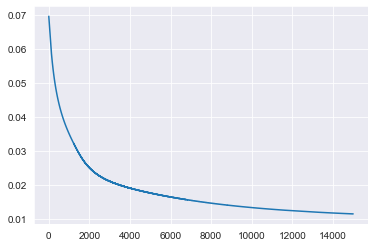

In [52]:
input = torch.tensor(x, dtype=torch.float)
target = torch.tensor(y, dtype=torch.float)


EPOCHS = 15000

printProgressBar(0, EPOCHS, prefix = 'Progress:', suffix = 'Complete', length = 50)
loss = []
for epoch in range(EPOCHS):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    # output, hidden = rnn(input[0,:].reshape(1,-1), hidden)
    loss.append(train(input, target))
    printProgressBar(epoch + 1, EPOCHS, prefix='Loss: {:.4f} Progress: '.format(loss[-1]), suffix='Complete', length=50)
    if epoch%150==0:
        get_pic(rnn, epoch, loss, input, x)
plt.plot(loss)

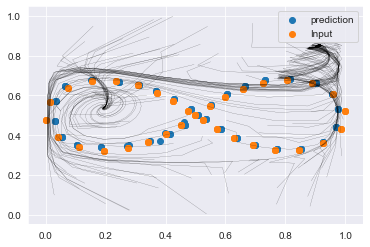

In [54]:
OUTPUT = []
hidden = rnn.initHidden()
for i in range(input.size()[0]):
    output, hidden = rnn.forward(input[i].reshape(1,-1), hidden)
    OUTPUT.append(output.detach().numpy())
output = np.vstack(OUTPUT)
plt.scatter(output[:,0], output[:,1], label='prediction')
plt.scatter(x[:,0], x[:,1], label='Input')
plt.legend()

for j in range (100):
    out = torch.tensor(np.random.uniform(low=0, high=1, size=(1,2)), dtype=torch.float)
    hidden = rnn.initHidden()
    OUT0, OUT1 = [], []
    for i in range(100):
        OUT0.append(out[0,0].item())
        OUT1.append(out[0,1].item())
        out, hidden = rnn.forward(out, hidden)
    plt.plot(OUT0, OUT1, linewidth=0.125, c='black')